In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install kmodes
!pip install lime
!pip install shap

In [4]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from kmodes.kmodes import KModes
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [5]:
# helper function for models evaluation adn performance comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report

def evaluate_model(model,model_Name, x_val, y_val):
    # Evaluate the model
    y_pred_probs = model.predict(x_val)
    # Convert probabilities to binary class labels based on a threshold (e.g., 0.5)
    y_pred_classes = (y_pred_probs > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred_classes)
    precision = precision_score(y_val, y_pred_classes, average='micro')
    recall = recall_score(y_val, y_pred_classes, average='micro')
    f1 = f1_score(y_val, y_pred_classes, average='micro')
    # Create DataFrame to store metrics
    metrics_df = pd.DataFrame({
        'Model': [model_Name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

    return metrics_df


In [6]:
file_path = '/content/drive/My Drive/heart.csv'
df = pd.read_csv(file_path, sep=',', encoding='utf-8')
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [8]:
print(df.isnull().sum())

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


**demographic details**

In [9]:
import pandas as pd

# =======================
# 1. CLASS DISTRIBUTION
# =======================
print("===== CLASS DISTRIBUTION =====")
class_counts = df['target'].value_counts()
class_percent = df['target'].value_counts(normalize=True) * 100

print(pd.DataFrame({
    "Count": class_counts,
    "Percent": class_percent.round(2)
}))
print("\n")

# =======================
# 2. AGE STATISTICS
# Use correct column ↓
# =======================
age_col = "age" if "age" in df.columns else "age_bin"

print("Using age column:", age_col)

print("===== AGE STATISTICS =====")
print(f"Mean age: {df[age_col].mean():.2f}")
print(f"SD age:   {df[age_col].std():.2f}")
print(f"Min age:  {df[age_col].min()}")
print(f"Max age:  {df[age_col].max()}")
print("\n")

# =======================
# 3. GENDER DISTRIBUTION
# =======================
print("===== GENDER DISTRIBUTION =====")
gender_counts = df['sex'].value_counts()
gender_percent = df['sex'].value_counts(normalize=True) * 100

gender_table = pd.DataFrame({
    "Count": gender_counts,
    "Percent": gender_percent.round(2)
})

gender_table.index = ["Female (0)", "Male (1)"]
print(gender_table)
print("\n")


===== CLASS DISTRIBUTION =====
        Count  Percent
target                
1         629    52.86
0         561    47.14


Using age column: age
===== AGE STATISTICS =====
Mean age: 53.72
SD age:   9.36
Min age:  28
Max age:  77


===== GENDER DISTRIBUTION =====
            Count  Percent
Female (0)    909    76.39
Male (1)      281    23.61




**Binning age column**

In [10]:
print(df['age'].dtype)
print(df['age'].unique())
print(df['age'].isna().sum())


int64
[40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71]
0


In [11]:
# Step 1: Bin the age values
df['age_bin'] = pd.cut(df['age'],
                       bins=[27, 39, 49, 59, 69, 77],
                       labels=[0, 1, 2, 3, 4],
                       include_lowest=True)

# Step 2: Check how many are NaN
print("Missing after binning:", df['age_bin'].isna().sum())

# Step 3: Drop rows with NaN in age_bin
df = df[df['age_bin'].notna()]

# Step 4: Convert to int
df['age_bin'] = df['age_bin'].astype(int)

# Step 5: Drop original age
df.drop('age', axis=1, inplace=True)


Missing after binning: 0


In [12]:
print(df[['age_bin']].head(10))


   age_bin
0        1
1        1
2        0
3        1
4        2
5        0
6        1
7        2
8        0
9        1


In [13]:
df = df.fillna(df.mean())

In [14]:
df['sex'] = df['sex'].astype('category')  # Example: Ensure `sex` is categorical
df = pd.get_dummies(df, columns=['chest pain type', 'resting ecg', 'ST slope'], drop_first=True)


In [15]:
df = df.apply(pd.to_numeric, errors='coerce')


In [16]:
print(df.head())  # View cleaned data
print(df.info())  # Check data types and ensure numeric types


   sex  resting bp s  cholesterol  fasting blood sugar  max heart rate  \
0    1           140          289                    0             172   
1    0           160          180                    0             156   
2    1           130          283                    0              98   
3    0           138          214                    0             108   
4    1           150          195                    0             122   

   exercise angina  oldpeak  target  age_bin  chest pain type_2  \
0                0      0.0       0        1               True   
1                0      1.0       1        1              False   
2                0      0.0       0        0               True   
3                1      1.5       1        1              False   
4                0      0.0       0        2              False   

   chest pain type_3  chest pain type_4  resting ecg_1  resting ecg_2  \
0              False              False          False          False   
1     

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ['age_bin', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
df[numeric_features] = scaler.fit_transform(df[numeric_features])


## **Clustering**

In [18]:
X = df.drop('target', axis=1)

In [19]:
cost = []
num_clusters = range(1,6) # 1 to 5
for i in list(num_clusters):
    kmode = KModes(n_clusters=i, init = "Huang", n_init = 5, verbose=0,random_state=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)


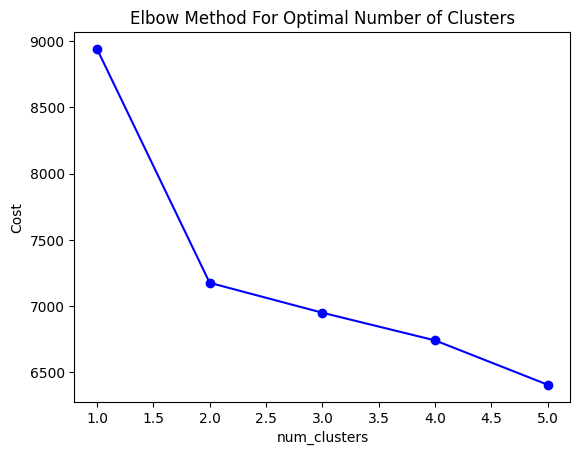

In [20]:
plt.plot(num_clusters, cost, 'bo-')
plt.xlabel('num_clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [21]:
km = KModes(n_clusters=2, init = "Huang", n_init = 5,random_state=1)
clusters = km.fit_predict(df)
clusters

array([1, 0, 1, ..., 0, 0, 1], dtype=uint16)

In [22]:
df.insert(0,"clusters",clusters,True)

df.head()

,clusters,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,age_bin,chest pain type_2,chest pain type_3,chest pain type_4,resting ecg_1,resting ecg_2,ST slope_1,ST slope_2,ST slope_3
0,1,1,0.427328,0.775674,0,1.265039,0,-0.849792,0,-0.965404,True,False,False,False,False,True,False,False
1,0,0,1.516587,-0.299512,0,0.637758,0,0.071119,1,-0.965404,False,True,False,False,False,False,True,False
2,1,1,-0.117301,0.716489,0,-1.636136,0,-0.849792,0,-2.005070,True,False,False,True,False,True,False,False
3,0,0,0.318402,0.035867,0,-1.244085,1,0.531575,1,-0.965404,False,False,True,False,False,False,True,False
4,1,1,0.971958,-0.151550,0,-0.695214,0,-0.849792,0,0.074262,False,True,False,False,False,True,False,False


In [23]:
# Drop duplicate 'clusters' columns if they exist
df = df.loc[:, ~df.columns.duplicated()]


In [24]:
df.head()


,clusters,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,age_bin,chest pain type_2,chest pain type_3,chest pain type_4,resting ecg_1,resting ecg_2,ST slope_1,ST slope_2,ST slope_3
0,1,1,0.427328,0.775674,0,1.265039,0,-0.849792,0,-0.965404,True,False,False,False,False,True,False,False
1,0,0,1.516587,-0.299512,0,0.637758,0,0.071119,1,-0.965404,False,True,False,False,False,False,True,False
2,1,1,-0.117301,0.716489,0,-1.636136,0,-0.849792,0,-2.005070,True,False,False,True,False,True,False,False
3,0,0,0.318402,0.035867,0,-1.244085,1,0.531575,1,-0.965404,False,False,True,False,False,False,True,False
4,1,1,0.971958,-0.151550,0,-0.695214,0,-0.849792,0,0.074262,False,True,False,False,False,True,False,False


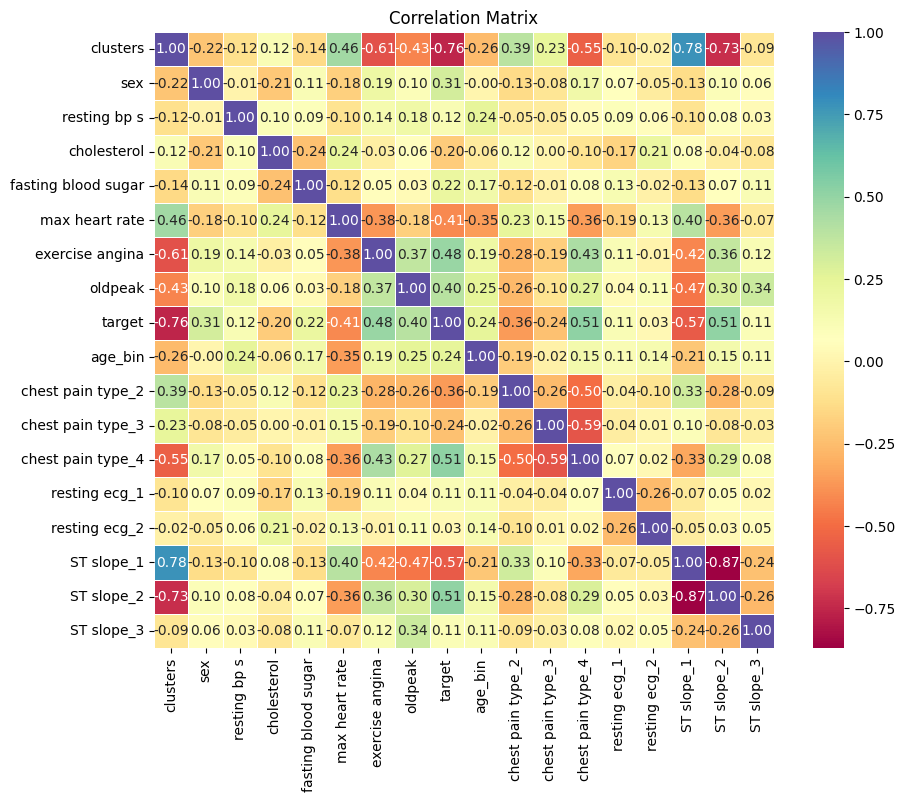

In [25]:
# Set up figure
plt.figure(figsize=(10, 8))

# Draw correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=.5)

# Show the figure
plt.title('Correlation Matrix')
plt.show()

In [26]:
pd.crosstab(df["clusters"], df["target"])


target,0,1
clusters,,
0,71,557
1,490,72


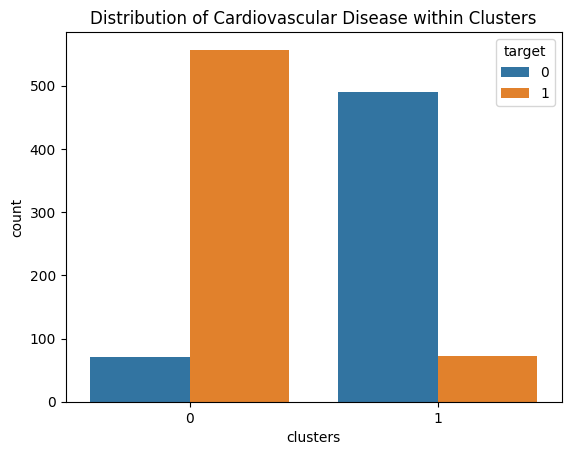

In [27]:
sns.countplot(x='clusters', hue='target', data=df)
plt.title('Distribution of Cardiovascular Disease within Clusters')
plt.show()

In [48]:
X = pd.get_dummies(df.drop("target", axis=1))
y = df["target"]         # Extract the target column


In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
print(f"Number of training samples: {len(x_train)}")
print(f"Number of testing samples: {len(x_test)}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of testing samples: {len(y_test)}")

Number of training samples: 952
Number of testing samples: 238
Number of training samples: 952
Number of testing samples: 238


# **Models Implementation**

### **Simple feed forward Neural network**

In [51]:
# Option A: single output neuron (sigmoid) + binary_crossentropy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Prepare X, y
X = pd.get_dummies(df.drop("target", axis=1))
y = df["target"].astype(int)   # ensure ints 0/1

# Split train/test and create a validation set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val   = scaler.transform(x_val)
x_test  = scaler.transform(x_test)

# Build model with single output neuron
model_simple = Sequential()
model_simple.add(Dense(64, input_shape=(x_train.shape[1],), activation='relu'))
model_simple.add(Dense(32, activation='relu'))
model_simple.add(Dense(1, activation='sigmoid'))  # single output

model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_simple.fit(x_train, y_train, epochs=32, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.5455 - loss: 0.6808 - val_accuracy: 0.8639 - val_loss: 0.4668
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8358 - loss: 0.4620 - val_accuracy: 0.8901 - val_loss: 0.3402
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8699 - loss: 0.3644 - val_accuracy: 0.8848 - val_loss: 0.3010
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8698 - loss: 0.3342 - val_accuracy: 0.8848 - val_loss: 0.2872
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8620 - loss: 0.3315 - val_accuracy: 0.8691 - val_loss: 0.2805
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8596 - loss: 0.3151 - val_accuracy: 0.8691 - val_loss: 0.2789
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8881 - loss: 0.2804 - val_accuracy: 0.8691 - val_loss: 0.2810
Epoch 8/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8724 - loss: 0.2986 - val_accuracy: 0.8691 - val_los

In [53]:
# Evaluate
loss, acc = model_simple.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred_prob = model_simple.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred))

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9010 - loss: 0.2239
Test Accuracy: 0.9076
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

CONFUSION MATRIX:
[[103   9]
 [ 13 113]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       112
           1       0.93      0.90      0.91       126

    accuracy                           0.91       238
   macro avg       0.91      0.91      0.91       238
weighted avg       0.91      0.91      0.91       238



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8704 - loss: 0.2957 
Validation Loss: 0.3086564540863037
Validation Accuracy: 0.8848167657852173


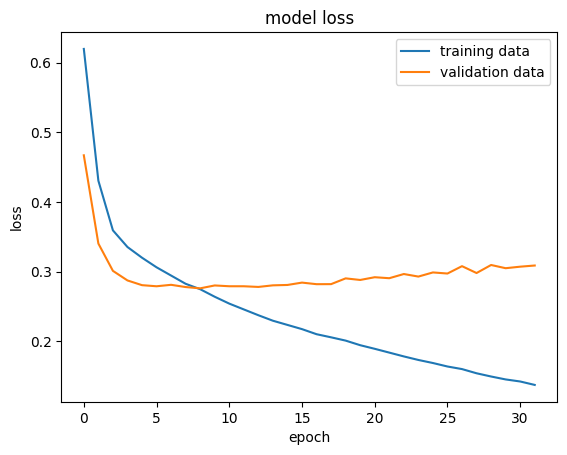

In [54]:
# Evaluate the model on the validation set
val_loss, val_acc = model_simple.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper right')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8704 - loss: 0.2957 
Validation Accuracy: 0.8848167657852173
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


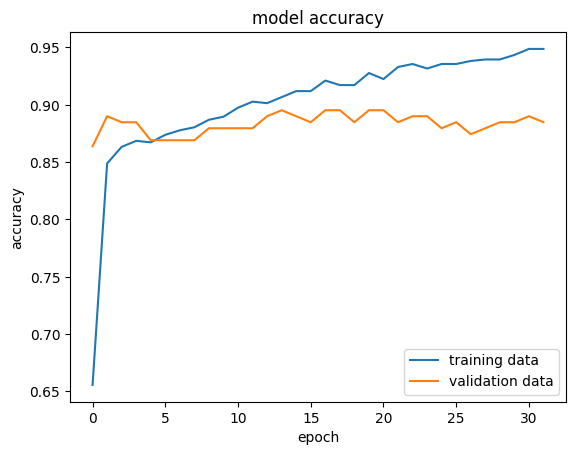

In [55]:


# Evaluate the model on the validation set
val_loss, val_accuracy = model_simple.evaluate(x_val, y_val)

# Print the validation accuracy
print("Validation Accuracy:", val_accuracy)

simple_fwd_nn = evaluate_model(model_simple,"simple_forward_NN",x_val,y_val)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'lower right')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


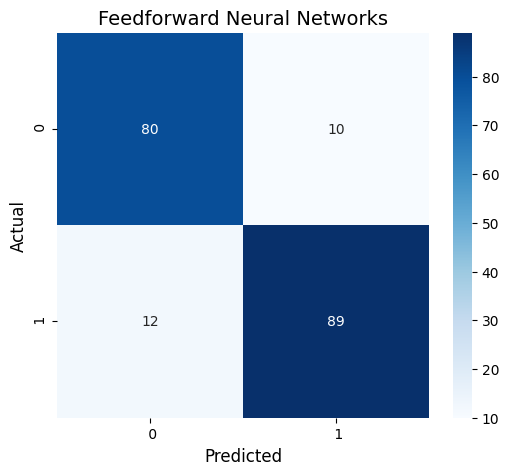

In [58]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on validation set
y_pred_prob = model_simple.predict(x_val)

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred_prob > 0.5).astype(int).ravel()
y_val_classes  = y_val.values if hasattr(y_val, "values") else y_val

# Generate confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Display heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[" 0", " 1"],
            yticklabels=[" 0", " 1"])
plt.title('Feedforward Neural Networks', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


# ***CNN Model***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming df is your full DataFrame with 'target' and feature columns

# Step 1: Separate features and labels
X = df.drop('target', axis=1)
y = df['target']

# Step 2: One-hot encode categorical features
X_encoded = pd.get_dummies(X)

# Step 3: Ensure all values are float32 (important for TensorFlow)
X_encoded = X_encoded.astype(np.float32)
y = y.astype(np.float32)

# Step 4: Train-validation split
x_train, x_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: Reshape for Conv1D
x_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.values.reshape(x_val.shape[0], x_val.shape[1], 1)

# Step 6: Build the CNN model
model_cnn = Sequential()

# 1st Conv1D layer
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))

# 2nd Conv1D layer
model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

# Flatten and Dense layers
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(1, activation='sigmoid'))  # Output layer

# Step 7: Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history = model_cnn.fit(x_train, y_train, epochs=32, batch_size=16, validation_data=(x_val, y_val))





Epoch 1/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6765 - loss: 0.6010 - val_accuracy: 0.8067 - val_loss: 0.4053
Epoch 2/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8235 - loss: 0.3964 - val_accuracy: 0.8697 - val_loss: 0.3450
Epoch 3/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8727 - loss: 0.3440 - val_accuracy: 0.8739 - val_loss: 0.3049
Epoch 4/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8719 - loss: 0.3229 - val_accuracy: 0.8697 - val_loss: 0.2996
Epoch 5/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8672 - loss: 0.3375 - val_accuracy: 0.8908 - val_loss: 0.2836
Epoch 6/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8959 - loss: 0.2677 - val_accuracy: 0.8866 - val_loss: 0.2845
Epoch 7/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8692 - loss: 0.3360 - val_accuracy: 0.8866 - val_loss: 0.3024
Epoch 8/32
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8928 - loss: 0.2645 - val_accuracy: 0.8950 - val_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Classification Report:

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89       107
         1.0       0.92      0.91      0.91       131

    accuracy                           0.90       238
   macro avg       0.90      0.90      0.90       238
weighted avg       0.90      0.90      0.90       238



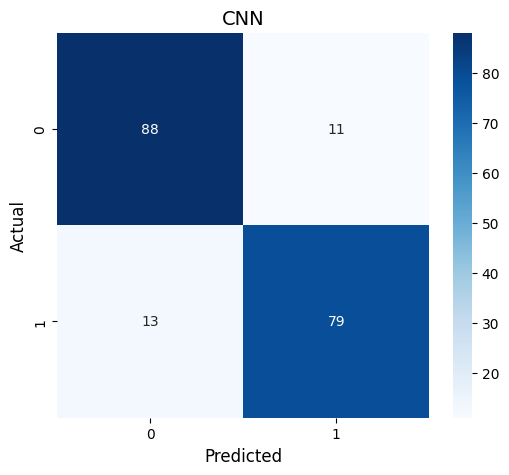

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 9: Predict on validation data
y_val_pred_prob = model_cnn.predict(x_val)  # gives probabilities
y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()  # convert to class labels 0 or 1

# Step 10: Generate Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred, digits=2))

# Step 11: Generate Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('CNN', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

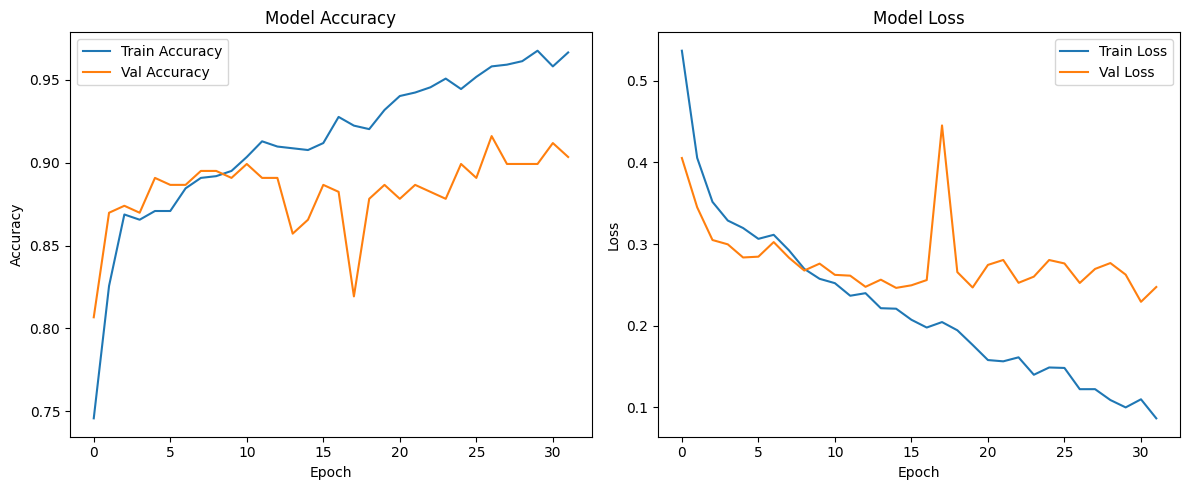

In [ ]:
# Step 9: Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



## **ML MODELS**

# **Stacking Algorithm**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Assuming the data (df) is already preprocessed and split
# Ensure you're using your feature and target variables correctly
x = df.drop(['target'], axis=1)  # Features
y = df['target']  # Target variable

# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    random_state=42
)

# Define base models using ExtraTrees, DecisionTree, and random forest
base_models = [
    ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=42, n_jobs=-1)),
    ('DecisionTree', dt_model),  # Decision Tree model

]

# Instantiate the Logistic Regression model as the final estimator
lr_model = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear', random_state=42)

# Instantiate the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

# Train the StackingClassifier on the training data
stacking_classifier.fit(x_train, y_train)

# Make predictions on the training data
y_train_pred = stacking_classifier.predict(x_train)

# Make predictions on the test data
predictions = stacking_classifier.predict(x_test)

# Print some results (e.g., accuracy)
from sklearn.metrics import accuracy_score

print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.6f}")
print(f"Test Accuracy: {accuracy_score(y_test, predictions):.6f}")


Training Accuracy: 1.000000
Test Accuracy: 0.970588


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, predictions))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       107
           1       0.96      0.98      0.97       131

    accuracy                           0.97       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.97      0.97      0.97       238



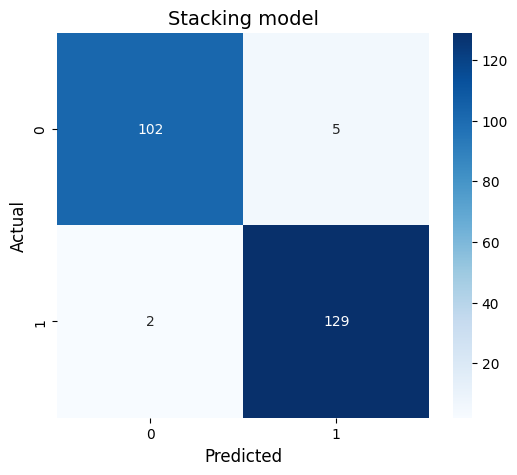

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict the results on the test set
predictions = stacking_classifier.predict(x_test)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
# Step 11: Generate Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Stacking model', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


**Stacking model on 7 and 123 seed values**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ================================
# Prepare features and target
# ================================
x = df.drop("target", axis=1)
y = df["target"]

# Seeds you want to test
seeds = [7, 123]

results = []

for seed in seeds:

    # ================================
    # Train-test split for this seed
    # ================================
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=seed, stratify=y
    )

    # ================================
    # Base models (seed applied here)
    # ================================
    dt_model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=4,
        random_state=seed
    )

    base_models = [
        ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=seed, n_jobs=-1)),
        ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=seed, n_jobs=-1)),
        ('DecisionTree', dt_model),
    ]

    # Final estimator
    lr_model = LogisticRegression(
        C=100,
        max_iter=100,
        penalty='l2',
        solver='liblinear',
        random_state=seed
    )

    # ================================
    # Stacking Classifier
    # ================================
    stacking_classifier = StackingClassifier(
        estimators=base_models,
        final_estimator=lr_model
    )

    stacking_classifier.fit(x_train, y_train)

    # ================================
    # Predictions
    # ================================
    y_pred = stacking_classifier.predict(x_test)

    # ================================
    # Metrics
    # ================================
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append([seed, acc, prec, rec, f1])

# ================================
# Results DataFrame
# ================================
df_stack = pd.DataFrame(results, columns=["Seed", "Accuracy", "Precision", "Recall", "F1"])

pd.set_option('display.precision', 10)
print(df_stack)

print("\nSummary Statistics:")
print(df_stack.describe())


   Seed      Accuracy    Precision        Recall            F1
0     7  0.9537815126  0.960000000  0.9523809524  0.9561752988
1   123  0.9873949580  0.976744186  1.0000000000  0.9882352941

Summary Statistics:
                 Seed      Accuracy     Precision        Recall            F1
count    2.0000000000  2.0000000000  2.0000000000  2.0000000000  2.0000000000
mean    65.0000000000  0.9705882353  0.9683720930  0.9761904762  0.9722052965
std     82.0243866176  0.0237682952  0.0118399275  0.0336717515  0.0226698401
min      7.0000000000  0.9537815126  0.9600000000  0.9523809524  0.9561752988
25%     36.0000000000  0.9621848739  0.9641860465  0.9642857143  0.9641902976
50%     65.0000000000  0.9705882353  0.9683720930  0.9761904762  0.9722052965
75%     94.0000000000  0.9789915966  0.9725581395  0.9880952381  0.9802202953
max    123.0000000000  0.9873949580  0.9767441860  1.0000000000  0.9882352941


# **Decision Trees**

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Accuracy: 1.0000
Validation Accuracy: 0.9244

Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       111
           1       0.94      0.92      0.93       127

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238



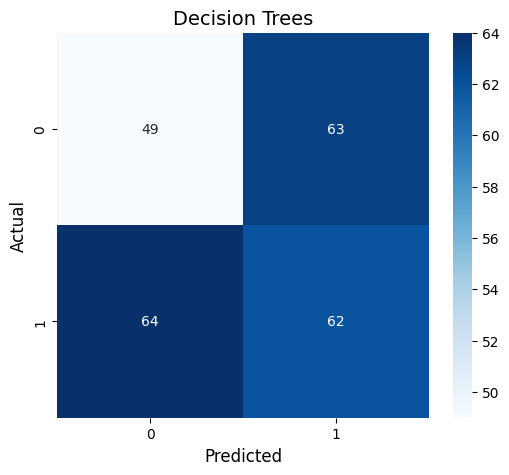

In [ ]:
#Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best model from GridSearchCV
best_clf = grid_search.best_estimator_

# Train the best model
best_clf.fit(x_train, y_train)

# Predict on the training and validation sets
y_train_pred = best_clf.predict(x_train)
y_val_pred = best_clf.predict(x_val)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Display results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nClassification Report on Validation Data:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_test, y_val_pred )

# Plot the confusion matrix using seaborn

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Decision Trees', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


**Decision Trees with 7 and 123 seed values**

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Seeds to evaluate
seeds = [7, 123]

# Parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

results = []

for seed in seeds:
    print(f"\n================ Seed {seed} ================")

    # Train-test split per seed
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )

    # Base model
    clf = DecisionTreeClassifier(random_state=seed)

    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(x_train, y_train)

    # Best model
    best_clf = grid_search.best_estimator_

    # Predictions
    y_pred = best_clf.predict(x_test)

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    # Store
    results.append([seed, acc, prec, rec, f1])

    # Optional printout
    print(f"Best Parameters: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))

# Create final results table
df_dt = pd.DataFrame(results, columns=["Seed", "Accuracy", "Precision", "Recall", "F1"])

pd.set_option('display.precision', 10)
print("\n================ FINAL SUMMARY ================")
print(df_dt)
print("\nSummary Statistics:")
print(df_dt.describe())



================ Seed 7 ================
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       112
           1       0.95      0.83      0.89       126

    accuracy                           0.89       238
   macro avg       0.89      0.89      0.89       238
weighted avg       0.90      0.89      0.89       238


================ Seed 123 ================
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       112
           1       0.89      0.94      0.91       126

    accuracy                           0.90       238
   macro avg       0.91      0.90      0.90       238
weighted avg       0.90      0.90      0.90       238


================ FINAL SUMMARY ================
   See

# **Random Forest**

Training accuracy (regularized Random Forest): 0.8739495798319328
Validation accuracy (regularized Random Forest): 0.8991596638655462
              precision    recall  f1-score   support

           0       0.53      0.50      0.52       112
           1       0.58      0.61      0.59       126

    accuracy                           0.56       238
   macro avg       0.56      0.56      0.56       238
weighted avg       0.56      0.56      0.56       238



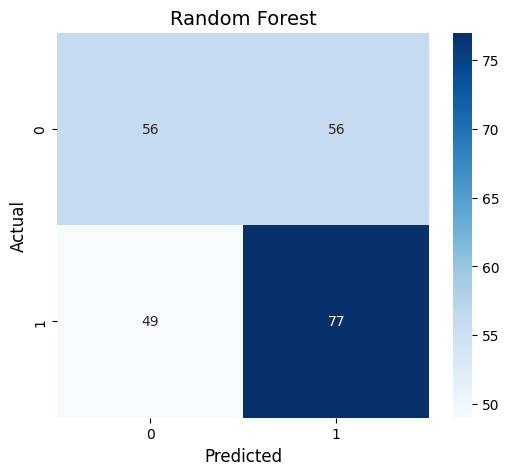

In [ ]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the Random Forest classifier with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', min_samples_split=5, min_samples_leaf=1, max_depth=20, bootstrap=True, random_state=42)

# Adjust min_impurity_decrease and bootstrap as needed
clf_regularized_rf = RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.01, bootstrap=True, random_state=42)

# Train the regularized Random Forest model on the training set
clf_regularized_rf.fit(x_train, y_train)

# Predict classes for training and validation sets
y_train_pred = clf_regularized_rf.predict(x_train)
y_val_pred = clf_regularized_rf.predict(x_val)

# Calculate accuracy for training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the results
print("Training accuracy (regularized Random Forest):", train_accuracy)
print("Validation accuracy (regularized Random Forest):", val_accuracy)


# Printing the classification report
print(classification_report(y_test, y_val_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_val_pred )

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Random Forest', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


# **Logistic regression**

Accuracy: 0.9033613445378151
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       112
           1       0.89      0.94      0.91       126

    accuracy                           0.90       238
   macro avg       0.91      0.90      0.90       238
weighted avg       0.90      0.90      0.90       238



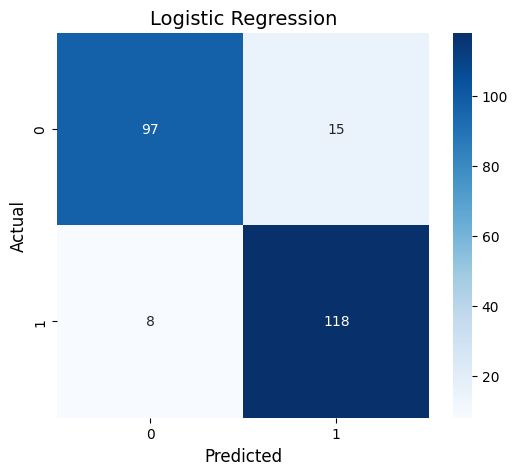

In [ ]:
#Logistic regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Standardizing the features (mean=0, variance=1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Initializing and training the logistic regression model
logreg = LogisticRegression(max_iter=1000,  penalty='l1', solver='saga')
logreg.fit(x_train_scaled, y_train)

# Making predictions on the test set
y_pred = logreg.predict(x_test_scaled)

# Evaluating the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Printing the classification report
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Logistic Regression', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Seeds you want to evaluate
seeds = [7, 123]

results = []

for seed in seeds:
    print(f"\n================ Seed {seed} ================")

    # -----------------------------
    # 1. Train-test split
    # -----------------------------
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )

    # -----------------------------
    # 2. Standardization (fit ONLY on training)
    # -----------------------------
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # -----------------------------
    # 3. Logistic Regression (L1)
    # -----------------------------
    logreg = LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=1000,
        random_state=seed
    )
    logreg.fit(x_train_scaled, y_train)

    # -----------------------------
    # 4. Predictions
    # -----------------------------
    y_pred = logreg.predict(x_test_scaled)

    # -----------------------------
    # 5. Metrics
    # -----------------------------
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append([seed, acc, prec, rec, f1])

    # Optional detailed output
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred))


# ==================================
# Final results summary
# ==================================
df_logreg = pd.DataFrame(results, columns=["Seed", "Accuracy", "Precision", "Recall", "F1"])

pd.set_option('display.precision', 10)
print("\n================ FINAL SUMMARY ================")
print(df_logreg)

print("\nSummary Statistics:")
print(df_logreg.describe())



================ Seed 7 ================
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       112
           1       0.93      0.87      0.90       126

    accuracy                           0.89       238
   macro avg       0.90      0.90      0.89       238
weighted avg       0.90      0.89      0.90       238


================ Seed 123 ================
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       112
           1       0.88      0.94      0.91       126

    accuracy                           0.90       238
   macro avg       0.90      0.90      0.90       238
weighted avg       0.90      0.90      0.90       238


================ FINAL SUMMARY ================
   Seed      Accuracy     Precision        Recall            F1
0     7  0.8949579832  0.9316239316  0.8650793651  0.8971193416
1   123  0.8991596639  0.8805970149  0.9365079365  0.9076923077

Summary Statistics

# **XGBoost**

XGBoost Accuracy: 89.92%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       107
           1       0.88      0.94      0.91       131

    accuracy                           0.90       238
   macro avg       0.90      0.89      0.90       238
weighted avg       0.90      0.90      0.90       238



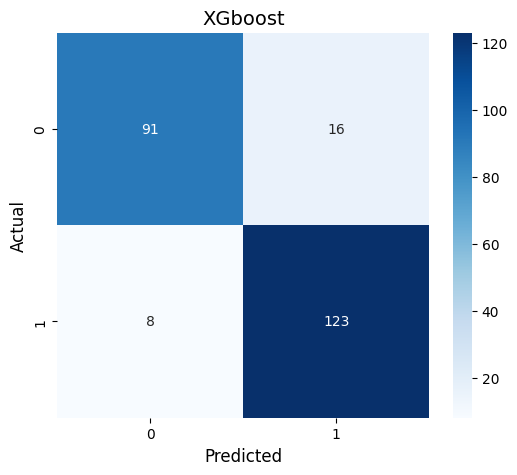

In [ ]:
#XGBoost
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Assuming your data is already loaded in X and y
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Initialize the XGBoost model
xg_model = xgb.XGBClassifier(random_state=42, max_depth=3, learning_rate=0.001)

# Step 2: Train the model
xg_model.fit(x_train, y_train)

# Step 3: Make predictions on the test data
y_pred_xg = xg_model.predict(x_test)

# Step 4: Evaluate the model
accuracy_xg = accuracy_score(y_test, y_pred_xg)
print(f"XGBoost Accuracy: {accuracy_xg * 100:.2f}%")

# Additional evaluation metrics (Precision, Recall, F1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xg))

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xg)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('XGboost', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()



# **95% CI for top 3 models using 7, 42 and 123 seed value**

In [ ]:
import numpy as np
import pandas as pd

# =====================================================
#  Function: compute mean, sd, and 95% CI
# =====================================================
def compute_ci(values):
    values = np.array(values)
    mean = values.mean()
    sd = values.std(ddof=1)
    se = sd / np.sqrt(len(values))
    ci_low = mean - 1.96 * se
    ci_high = mean + 1.96 * se
    return mean, sd, ci_low, ci_high


# =====================================================
#  INSERT ALL YOUR METRICS HERE
# =====================================================

# ---- Decision Tree ----
dt_acc  = [0.9537815126, 0.9579831933, 0.9873949580]
dt_prec = [0.9600000000, 0.9754098361, 0.9767441860]
dt_rec  = [0.9523809524, 0.9444444444, 1.0000000000]
dt_f1   = [0.9561752988, 0.9596774194, 0.9882352941]

# ---- Logistic Regression ----
lr_acc  = [0.8949579832, 0.9033613445, 0.8991596639]
lr_prec = [0.9316239316, 0.9047619048, 0.8805970149]
lr_rec  = [0.8650793651, 0.8991596639, 0.9365079365]
lr_f1   = [0.8971193416, 0.9000000000, 0.9076923077]

# ---- Stacking ----
stack_acc  = [0.9537815126, 0.9705880000, 0.9873949580]
stack_prec = [0.9600000000, 0.9700000000, 0.9767441860]
stack_rec  = [0.9523809524, 0.9705880000, 1.0000000000]
stack_f1   = [0.9561752988, 0.9700000000, 0.9882352941]


# =====================================================
#  BUILD TABLE
# =====================================================
models = {
    "Decision Tree": {"acc": dt_acc, "prec": dt_prec, "rec": dt_rec, "f1": dt_f1},
    "Logistic Regression": {"acc": lr_acc, "prec": lr_prec, "rec": lr_rec, "f1": lr_f1},
    "Stacking": {"acc": stack_acc, "prec": stack_prec, "rec": stack_rec, "f1": stack_f1},
}

rows = []

for model, metrics in models.items():
    # Accuracy
    acc_mean, acc_sd, acc_low, acc_high = compute_ci(metrics["acc"])
    # Precision
    prec_mean, prec_sd, prec_low, prec_high = compute_ci(metrics["prec"])
    # Recall
    rec_mean, rec_sd, rec_low, rec_high = compute_ci(metrics["rec"])
    # F1
    f1_mean, f1_sd, f1_low, f1_high = compute_ci(metrics["f1"])

    rows.append([
        model,
        acc_mean, acc_sd, acc_low, acc_high,
        prec_mean, prec_sd, prec_low, prec_high,
        rec_mean, rec_sd, rec_low, rec_high,
        f1_mean, f1_sd, f1_low, f1_high
    ])

df_final = pd.DataFrame(rows, columns=[
    "Model",
    "Accuracy_Mean", "Accuracy_SD", "Accuracy_CI_Lower", "Accuracy_CI_Upper",
    "Precision_Mean", "Precision_SD", "Precision_CI_Lower", "Precision_CI_Upper",
    "Recall_Mean", "Recall_SD", "Recall_CI_Lower", "Recall_CI_Upper",
    "F1_Mean", "F1_SD", "F1_CI_Lower", "F1_CI_Upper"
])

pd.set_option("display.precision", 10)
print(df_final)


                 Model  Accuracy_Mean   Accuracy_SD  Accuracy_CI_Lower  \
0        Decision Tree   0.9663865546  0.0183147014       0.9456615189   
1  Logistic Regression   0.8991596639  0.0042016807       0.8944050146   
2             Stacking   0.9705881569  0.0168067227       0.9515695598   

   Accuracy_CI_Upper  Precision_Mean  Precision_SD  Precision_CI_Lower  \
0       0.9871115903    0.9707180074  0.0093060133        0.9601872620   
1       0.9039143131    0.9056609504  0.0255253358        0.8767763138   
2       0.9896067540    0.9689147287  0.0084246841        0.9593813012   

   Precision_CI_Upper   Recall_Mean     Recall_SD  Recall_CI_Lower  \
0        0.9812487528  0.9656084656  0.0300471341     0.9316069325   
1        0.9345455871  0.9002489885  0.0357267431     0.8598203728   
2        0.9784481561  0.9743229841  0.0240282335     0.9471324783   

   Recall_CI_Upper       F1_Mean         F1_SD   F1_CI_Lower   F1_CI_Upper  
0     0.9996099987  0.9680293374  0.0175862653  

**McNemar Tests**

In [ ]:
pred_dt    = y_val_pred       # Decision Tree
pred_lr    = y_pred           # Logistic Regression
pred_stack = predictions      # Stacking


from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

def run_mcnemar(y_true, pred1, pred2, name1, name2):
    # Build contingency table
    b01 = np.sum((pred1 == y_true) & (pred2 != y_true))  # model1 correct, model2 wrong
    b10 = np.sum((pred1 != y_true) & (pred2 == y_true))  # model1 wrong, model2 correct

    table = [[0, b01],
             [b10, 0]]

    # McNemar test (exact=True recommended for small numbers)
    result = mcnemar(table, exact=False, correction=True)

    print(f"\n===== McNemar Test: {name1} vs {name2} =====")
    print(f"b01 = {b01}, b10 = {b10}")
    print(f"Test statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")

    if result.pvalue < 0.05:
        print("➡ Significant difference (p < 0.05)")
    else:
        print("➡ No significant difference (p ≥ 0.05)")


# ============================================
# Run tests (use YOUR prediction variables)
# ============================================

run_mcnemar(y_test, pred_dt, pred_lr, "Decision Tree", "Logistic Regression")
run_mcnemar(y_test, pred_dt, pred_stack, "Decision Tree", "Stacking")
run_mcnemar(y_test, pred_lr, pred_stack, "Logistic Regression", "Stacking")



===== McNemar Test: Decision Tree vs Logistic Regression =====
b01 = 19, b10 = 100
Test statistic: 53.78151260504202
p-value: 2.2407127165192652e-13
➡ Significant difference (p < 0.05)

===== McNemar Test: Decision Tree vs Stacking =====
b01 = 8, b10 = 9
Test statistic: 0.0
p-value: 1.0
➡ No significant difference (p ≥ 0.05)

===== McNemar Test: Logistic Regression vs Stacking =====
b01 = 97, b10 = 17
Test statistic: 54.74561403508772
p-value: 1.3718501801217286e-13
➡ Significant difference (p < 0.05)


# **TabNet**

In [ ]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00


epoch 0  | loss: 1.66007 | val_0_accuracy: 0.48739 |  0:00:01s
epoch 10 | loss: 0.5187  | val_0_accuracy: 0.76891 |  0:00:05s
epoch 20 | loss: 0.38878 | val_0_accuracy: 0.86134 |  0:00:09s
epoch 30 | loss: 0.33591 | val_0_accuracy: 0.88235 |  0:00:12s
epoch 40 | loss: 0.31333 | val_0_accuracy: 0.88655 |  0:00:14s

Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_accuracy = 0.88655
TabNet Test Accuracy: 0.8865546218487395

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       112
           1       0.87      0.92      0.90       126

    accuracy                           0.89       238
   macro avg       0.89      0.88      0.89       238
weighted avg       0.89      0.89      0.89       238



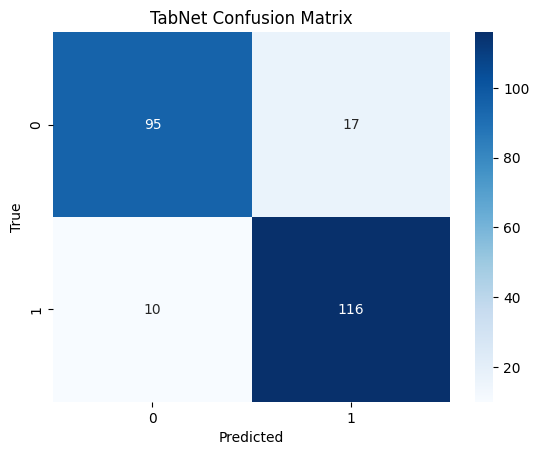

In [ ]:
import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch

import numpy as np

X_train_tab = np.array(x_train, dtype=np.float32)
X_test_tab  = np.array(x_test, dtype=np.float32)
y_train_tab = np.array(y_train, dtype=np.int64)
y_test_tab  = np.array(y_test, dtype=np.int64)

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

tabnet = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax',
    seed=42,
    verbose=10
)

tabnet.fit(
    X_train_tab, y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_tab = tabnet.predict(X_test_tab)

print("TabNet Test Accuracy:", accuracy_score(y_test_tab, y_pred_tab))
print("\nClassification Report:")
print(classification_report(y_test_tab, y_pred_tab))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_tab, y_pred_tab)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TabNet Confusion Matrix")
plt.show()
